# Book recommendation system with Truncated SVD

Parts 1 and 2 are the same as in the item-based cosine similarity recommendation model (notebook.ipynb).

--- 
### SUMMARY 
1. [Read the Data](#1)
2. [Exploratory Data Analysis](#2)
3. [Selecting components of SVD model](#3)
4. [Model evaluation and test/train split](#4)
5. [Predicting ratings for manually added user with SVD trained on the entire dataset](#5)
---

# 1. Read the Data
<a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics.pairwise import cosine_similarity
import pickle

pd.set_option('display.max_columns', None)   # Set to None to display all columns
pd.set_option('display.width', 1000)         # Set width to a high value to display columns next to each other

os.chdir('../')

In [2]:
# Importing datasets
books = pd.read_csv(r'dataset-kaggle\Books.csv')
users =pd.read_csv(r'dataset-kaggle\Users.csv')
ratings = pd.read_csv(r'dataset-kaggle\Ratings.csv')

C:\Users\macko\AppData\Local\Temp\ipykernel_7128\2562243880.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(r'dataset-kaggle\Books.csv')


In [3]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


For now we can disregard the users dataset to simplify.

In [6]:
ratings.shape

(1149780, 3)

In [7]:
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

No missing values in ratings df. 

In [8]:
ratings.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

The data types of ratings look good.

In [9]:
ratings['Book-Rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

0 is the most frequent rating, but according to the 0 is the dataset author's discussion post, it is implicit, meaning that the user did not review the book but may have clicked on the link with it to explore it.
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/discussion/201619

In the discussion post, the author says to develop algorithms with and without 0 rating and compare the performance so let's do it that way.


Let's look at books dataset.

In [10]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...


In [11]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [12]:
books[books.isnull().any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


It looks like the last 3 records from the filtered df above have mixed up columns.

Let's fix that.

In [13]:
indices_to_shift = [209538, 220731, 221678]
start_col_index = 2

for index in indices_to_shift:
    if index in books.index:
        row = books.loc[index].copy()

        # Get the values to be shifted
        values_to_shift = row[start_col_index:]

        # Shift and assign values to the columns one index to the right
        books.loc[index, books.columns[start_col_index + 1:]] = values_to_shift.values[:-1]

        # Fill the original 'Book-Author' column with NaN becuse we need to parse the Author from Title
        books.loc[index, books.columns[start_col_index]] = np.nan


# Display the modified DataFrame (showing a few rows around the affected indices)
books[books.isnull().any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",NaN,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",NaN,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",NaN,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...


For the three rows I need to parse the Book-Title to retrieve the Book-Author.

In [14]:
for index in indices_to_shift:
    print(books['Book-Title'].loc[index])

DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\";Michael Teitelbaum"
Peuple du ciel, suivi de 'Les Bergers\";Jean-Marie Gustave Le ClÃ?Â©zio"
DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\";James Buckley"


In [15]:
import re

indices_to_shift = [209538, 220731, 221678]

for index in indices_to_shift:
    book_title = books['Book-Title'].loc[index]

    # Parse Book-Title to extract author
    match = re.search(r'";(.*?)"', book_title)
    # Update
    if match:
        extracted_author = match.group(1)
        books.loc[index, 'Book-Author'] = extracted_author

    # Remove everything after '";'
    split_title = book_title.split('\";', 1)
    truncated_title = split_title[0]

    # Remove backslash
    if truncated_title.endswith('\\'):
        truncated_title = truncated_title[:-1]

    books.loc[index, 'Book-Title'] = truncated_title

In [16]:
books.loc[indices_to_shift[1]]

ISBN                                                          2070426769
Book-Title                         Peuple du ciel, suivi de 'Les Bergers
Book-Author                              Jean-Marie Gustave Le ClÃ?Â©zio
Year-Of-Publication                                                 2003
Publisher                                                      Gallimard
Image-URL-S            http://images.amazon.com/images/P/2070426769.0...
Image-URL-M            http://images.amazon.com/images/P/2070426769.0...
Image-URL-L            http://images.amazon.com/images/P/2070426769.0...
Name: 220731, dtype: object

Before:
- Peuple du ciel, suivi de 'Les Bergers\";Jean-Marie Gustave Le ClÃ?Â©zio"

After:
- Peuple du ciel, suivi de 'Les Bergers

Now let's see the remaining nans

In [17]:
books[books.isnull().any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


From amazon

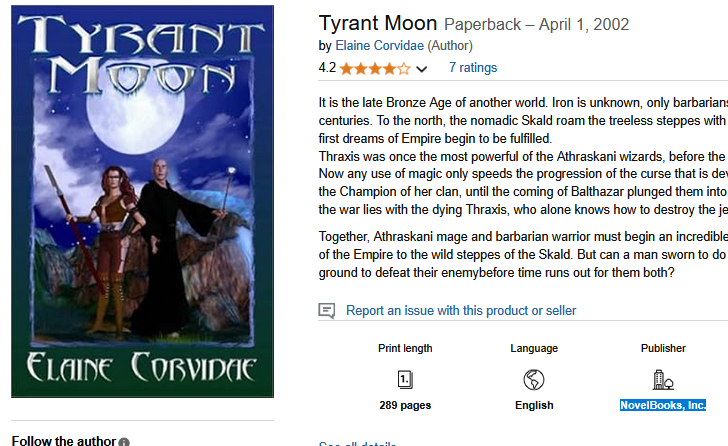

In [18]:
books[books['Book-Title'] == 'Tyrant Moon']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...


Only one book with that title (can't take other publisher)

In [19]:
# Check if exists
books[books['Publisher'] == 'NovelBooks, Inc.'].head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
126169,1591051827,The Guarder Factor,Shawn P. Madison,2003,"NovelBooks, Inc.",http://images.amazon.com/images/P/1591051827.0...,http://images.amazon.com/images/P/1591051827.0...,http://images.amazon.com/images/P/1591051827.0...
126707,1591051894,Sorrows of Adoration,Kimberly Chapman,2003,"NovelBooks, Inc.",http://images.amazon.com/images/P/1591051894.0...,http://images.amazon.com/images/P/1591051894.0...,http://images.amazon.com/images/P/1591051894.0...
144543,193169690X,The Anonymous Amanuensis,Judith B. Glad,2001,"NovelBooks, Inc.",http://images.amazon.com/images/P/193169690X.0...,http://images.amazon.com/images/P/193169690X.0...,http://images.amazon.com/images/P/193169690X.0...


In [20]:
# Just to confiorm the cover
books['Image-URL-S'].loc[128890]

'http://images.amazon.com/images/P/193169656X.01.THUMBZZZ.jpg'

Let's impute

In [21]:
books.loc[128890, 'Publisher'] = 'NovelBooks, Inc.'

Last two missing values.

In [22]:
books[books.isnull().any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


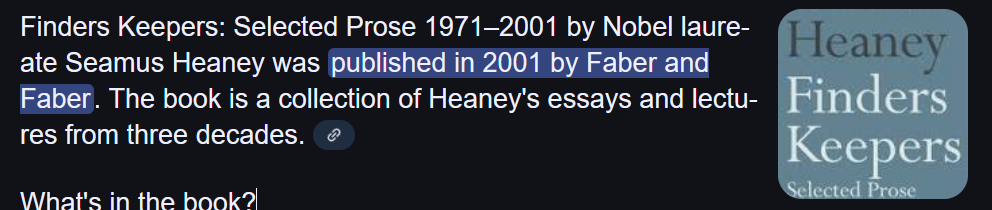

In [23]:
# Check if exists
books[books['Publisher'] == 'Faber and Faber'].head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
26551,0571169503,East of Wimbledon,Nigel Williams,1993,Faber and Faber,http://images.amazon.com/images/P/0571169503.0...,http://images.amazon.com/images/P/0571169503.0...,http://images.amazon.com/images/P/0571169503.0...
40116,0571169333,Arcadia,Tom Stoppard,1993,Faber and Faber,http://images.amazon.com/images/P/0571169333.0...,http://images.amazon.com/images/P/0571169333.0...,http://images.amazon.com/images/P/0571169333.0...
42218,0571134769,"All what jazz: A record diary, 1961-1971",Philip Larkin,1985,Faber and Faber,http://images.amazon.com/images/P/0571134769.0...,http://images.amazon.com/images/P/0571134769.0...,http://images.amazon.com/images/P/0571134769.0...


In [24]:
books.loc[129037, 'Publisher'] = 'Faber and Faber'

For the last missing value I will set the Author to Credit Suisse.  

In [25]:
books.loc[187689, 'Book-Author'] = 'Credit Suisse'

In [26]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

I will look at Year-Of-Publication column now.

In [27]:
books.dtypes

# books['Year-Of-Publication'].max()

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

In [28]:
# Convert the column to string first to use .str methods safely
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(str)
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [29]:
books.describe()

,Year-Of-Publication
count,271360.000000
mean,1959.761273
std,257.992836
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


The min and max values of Year-Of-Publication are suspicious, but I am not planning to use that column for the analysis.

In [30]:
old_books = books[books['Year-Of-Publication'] < 1900].sort_values('Year-Of-Publication')
old_books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
176,3150000335,Kabale Und Liebe,Schiller,0,"Philipp Reclam, Jun Verlag GmbH",http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...
179139,0349104786,Live From Golgotha,Gore Vidal,0,Abacus,http://images.amazon.com/images/P/0349104786.0...,http://images.amazon.com/images/P/0349104786.0...,http://images.amazon.com/images/P/0349104786.0...
179055,8804396156,Pupazzo Parlante Italian,R L Stine,0,Mondadori Italian,http://images.amazon.com/images/P/8804396156.0...,http://images.amazon.com/images/P/8804396156.0...,http://images.amazon.com/images/P/8804396156.0...


In [31]:
old_books = books[books['Year-Of-Publication'] > 2020].sort_values('Year-Of-Publication')
old_books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
183769,0590085417,Heidi,Johanna Spyri,2021,Scholastic,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...
246842,0380000059,CLOUT,D. GIBBONS,2024,Avon,http://images.amazon.com/images/P/0380000059.0...,http://images.amazon.com/images/P/0380000059.0...,http://images.amazon.com/images/P/0380000059.0...
118294,3442436893,Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.,Kathy Lette,2026,Goldmann,http://images.amazon.com/images/P/3442436893.0...,http://images.amazon.com/images/P/3442436893.0...,http://images.amazon.com/images/P/3442436893.0...


In [32]:
books['Book-Title'].value_counts()

Selected Poems                                                                                                                    27
Little Women                                                                                                                      24
Wuthering Heights                                                                                                                 21
The Secret Garden                                                                                                                 20
Dracula                                                                                                                           20
                                                                                                                                  ..
What Every Kid Should Know                                                                                                         1
The Seventh Enemy (A Brady Coyne Mystery)                            

Some titles appear to have duplicates but it may be due to a different publisher. 

In [33]:
books['ISBN'].value_counts()

0195153448    1
0746008481    1
0395219906    1
043916169X    1
0879235322    1
             ..
1568303823    1
0525947612    1
207036819X    1
2877306127    1
0767409752    1
Name: ISBN, Length: 271360, dtype: int64

In [34]:
title_counts = books['Book-Title'].value_counts()

# Filter the Series to keep only counts greater than 1
duplicate_titles = title_counts[title_counts > 1]

duplicate_titles

Selected Poems                                            27
Little Women                                              24
Wuthering Heights                                         21
The Secret Garden                                         20
Dracula                                                   20
                                                          ..
Mekong!                                                    2
Wolf's Head                                                2
Beverly Hills                                              2
House of Smoke                                             2
Real Boys: Rescuing Our Sons from the Myths of Boyhood     2
Name: Book-Title, Length: 19907, dtype: int64

OK, so the ISBN is unique across the entire dataset but there are 19907 titles that have more than one edition published. 

A book is a book so we will look at titles rather than ISBNs. 

Let's merge the two dfs on ISBN.

In [35]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [36]:
ratings.shape

(1149780, 3)

In [37]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# 2. Exploratory Data Analysis
<a id="2"></a>

In [38]:
merged = ratings.merge(books, on='ISBN')

In [39]:
merged.shape

(1031136, 10)

Clearly some ISBNs from books \were not rated.

In [40]:
merged.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


Let's make some visual representations of the data/

In [41]:
titles_grouped_implicit = merged.groupby('Book-Title')['Book-Rating'].agg([np.mean, 'count']).sort_values('count', ascending=False)
titles_grouped_implicit = titles_grouped_implicit.reset_index()
titles_grouped_implicit_10 = titles_grouped_implicit.head(10)

titles_grouped_implicit_10

,Book-Title,mean,count
0,Wild Animus,1.019584,2502
1,The Lovely Bones: A Novel,4.468726,1295
2,The Da Vinci Code,4.642539,898
3,A Painted House,3.231504,838
4,The Nanny Diaries: A Novel,3.530193,828
5,Bridget Jones's Diary,3.527607,815
6,The Secret Life of Bees,4.447028,774
7,Divine Secrets of the Ya-Ya Sisterhood: A Novel,3.437838,740
8,The Red Tent (Bestselling Backlist),4.334716,723
9,Angels &amp; Demons,3.708955,670


So looking at the count column, the most "Clicked" book is Wild Animus (implicit rating). 

But we mustn't look at the mean column from titles_grouped_implicit_10 because it includes the the 0 rating.

Let's filter it out to get the actual "explicit" average rating.

In [42]:
merged_explicit = merged[merged['Book-Rating'] > 0]
titles_grouped_explicit = merged_explicit.groupby('Book-Title')['Book-Rating'].agg([np.mean, 'count'])
titles_grouped_explicit = titles_grouped_explicit.reset_index()

# Filter books with +100 reviews
titles_grouped_explicit_100clicks = titles_grouped_explicit.query('count > 100').sort_values('mean', ascending=False)
titles_grouped_explicit_10 = titles_grouped_explicit_100clicks.head(10)
titles_grouped_explicit_10

,Book-Title,mean,count
119061,"The Two Towers (The Lord of the Rings, Part 2)",9.330882,136
115128,"The Return of the King (The Lord of the Rings,...",9.213592,103
45381,Harry Potter and the Goblet of Fire (Book 4),9.125506,247
45400,Harry Potter and the Sorcerer's Stone (Book 1),9.062500,176
45385,Harry Potter and the Order of the Phoenix (Boo...,9.047393,211
45393,Harry Potter and the Prisoner of Azkaban (Book 3),9.043321,277
123681,To Kill a Mockingbird,8.977528,267
45403,Harry Potter and the Sorcerer's Stone (Harry P...,8.936508,315
34428,Ender's Game (Ender Wiggins Saga (Paperback)),8.920530,151
104949,The Fellowship of the Ring (The Lord of the Ri...,8.882927,205


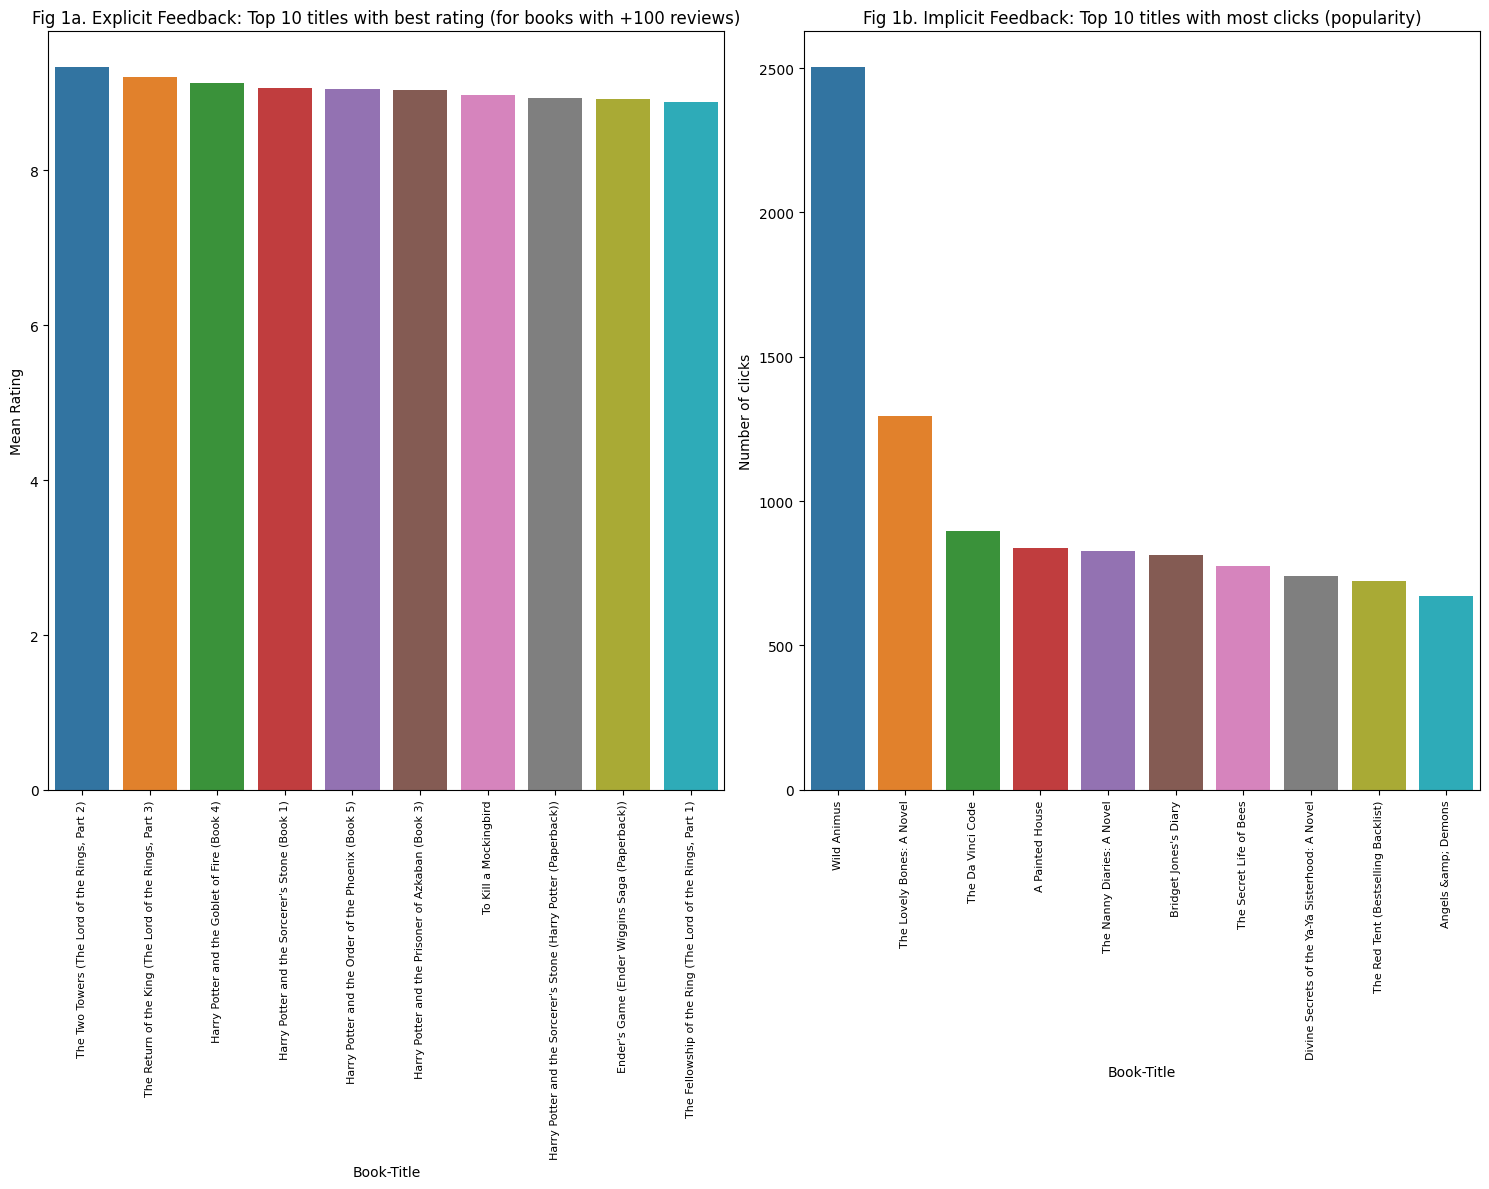

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 12)) # Added figsize for better visualization

sns.barplot(data=titles_grouped_explicit_10,
            x='Book-Title',
            y='mean',
            ax=ax0)
ax0.set_title('Fig 1a. Explicit Feedback: Top 10 titles with best rating (for books with +100 reviews)')
ax0.tick_params(axis='x', rotation=90, labelsize=8) # Rotate x-axis labels for readability
# ax0.set_xlabel('Book Title')
ax0.set_ylabel('Mean Rating')

sns.barplot(data=titles_grouped_implicit_10,
            x='Book-Title',
            y='count',
            ax=ax1)
ax1.set_title('Fig 1b. Implicit Feedback: Top 10 titles with most clicks (popularity)')
ax1.tick_params(axis='x', rotation=90, labelsize=8) # Rotate x-axis labels for readability
# ax1.set_xlabel('Book Title')
ax1.set_ylabel('Number of clicks')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

Out of curiosity, let's check the average explicit rating of the most clicked titles (Fig 1b)

In [44]:
top10_clicked_titles = titles_grouped_implicit_10['Book-Title'].tolist()

titles_grouped_explicit_10_rating = titles_grouped_explicit_100clicks[titles_grouped_explicit_100clicks['Book-Title'].isin(top10_clicked_titles)]

# Plug in the counts from titles_grouped_implicit_10
titles_grouped_explicit_10_rating = titles_grouped_explicit_10_rating.drop('count', axis=1)

titles_grouped_implicit_10_for_merge = titles_grouped_implicit_10.drop('mean', axis=1)

explicit_rating_for_top_10_implicit = titles_grouped_explicit_10_rating.merge(titles_grouped_implicit_10_for_merge, on='Book-Title')

explicit_rating_for_top_10_implicit = explicit_rating_for_top_10_implicit.sort_values('count', ascending=False)

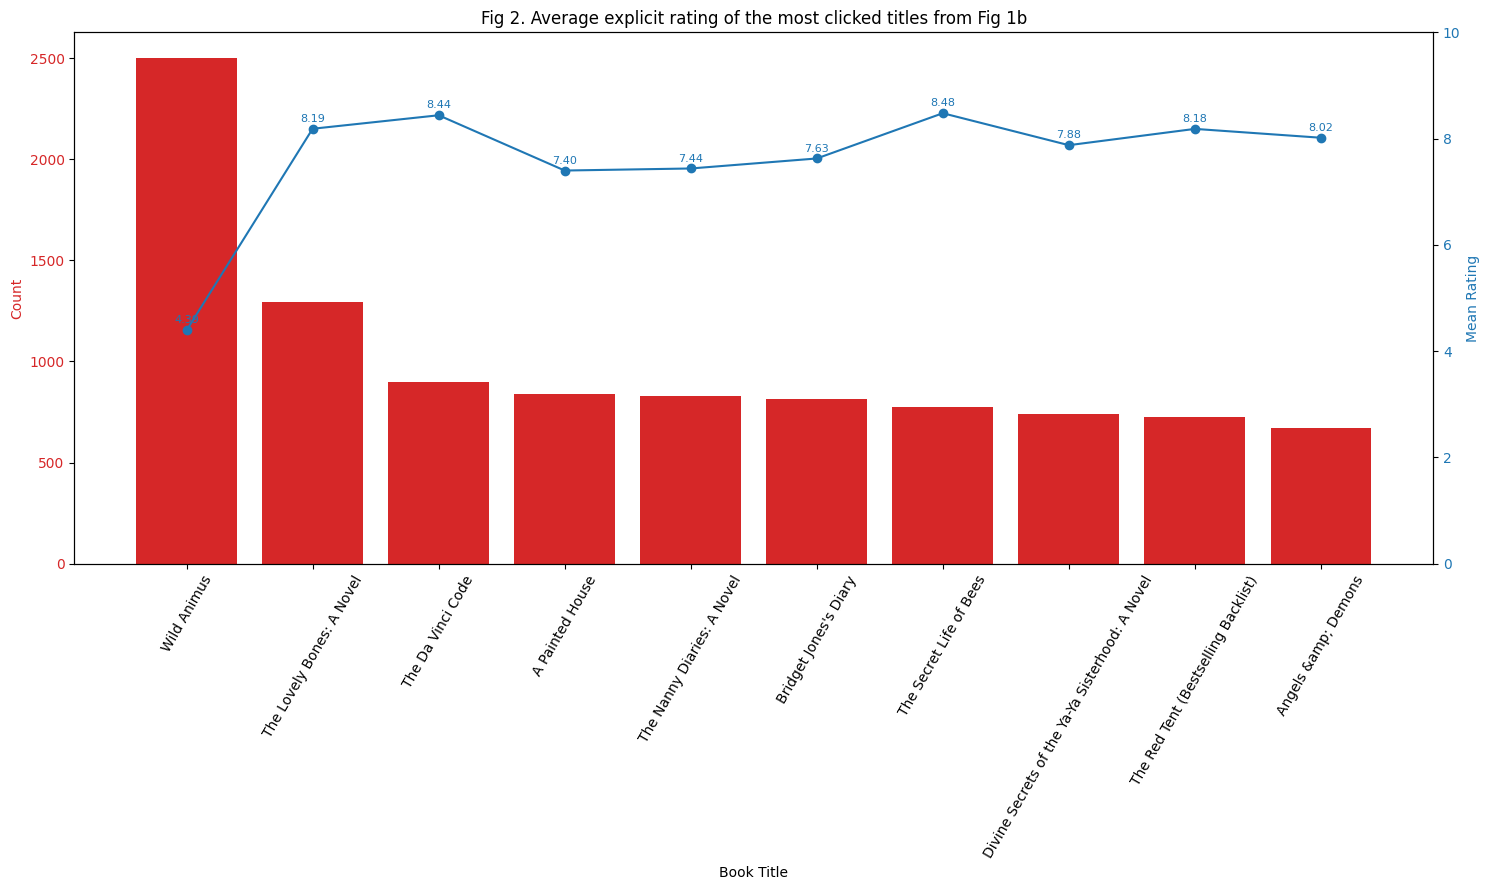

In [45]:
fig, ax1 = plt.subplots(figsize=(15, 9))

# Plot 'count' on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Book Title')
ax1.set_ylabel('Count', color=color)
ax1.bar(explicit_rating_for_top_10_implicit['Book-Title'], explicit_rating_for_top_10_implicit['count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=60)

# Create a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Mean Rating', color=color)
ax2.plot(explicit_rating_for_top_10_implicit['Book-Title'], explicit_rating_for_top_10_implicit['mean'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 10)  # Set the limits for the secondary y-axis

# Add labels
for x, y in zip(explicit_rating_for_top_10_implicit['Book-Title'], explicit_rating_for_top_10_implicit['mean']):
    ax2.annotate(f'{y:.2f}', (x, y),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center',
                 fontsize=8,
                 color=color)

plt.title('Fig 2. Average explicit rating of the most clicked titles from Fig 1b')
fig.tight_layout()
plt.show()

Interesting how the book with the most clicks is so poorly rated.

- Fun fact: I checked and it's a book about a drug dealer called Sam Altman.

In [46]:
titles_grouped_explicit.sort_values('count', ascending=False)

,Book-Title,mean,count
110229,The Lovely Bones: A Novel,8.185290,707
132241,Wild Animus,4.390706,581
102703,The Da Vinci Code,8.439271,494
116196,The Secret Life of Bees,8.477833,406
111950,The Nanny Diaries: A Novel,7.437659,393
...,...,...,...
54565,Journeys with Elijah: Eight Tales of the Prophet,10.000000,1
54564,Journeys to Door County,8.000000,1
54562,Journeys of Simplicity: Traveling Light With T...,6.000000,1
54561,Journeys into Past Lives,8.000000,1


In [47]:
merged_explicit.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [48]:
readers_10reviews = merged_explicit.groupby('User-ID')['Book-Rating'].agg('count').reset_index()
readers_10reviews = readers_10reviews.sort_values('Book-Rating', ascending=False)
readers_10reviews = readers_10reviews[readers_10reviews['Book-Rating'] >= 10]
readers_10reviews = readers_10reviews['User-ID'].tolist()

len(readers_10reviews)

6589

Let's use that list to filter merged_explicit.

In [49]:
merged_explicit_filtered = merged_explicit[merged_explicit['User-ID'].isin(readers_10reviews)]
merged_explicit_filtered.shape

(261899, 10)

So that's 6589 users responsible for 261899 reviews.

In [50]:
264899 / 6589

40.20321748368493

Let's get popular titles with +30 reviews

In [51]:
titles_30reviews = merged_explicit_filtered.groupby('Book-Title')['Book-Rating'].agg('count').reset_index()
titles_30reviews = titles_30reviews.sort_values('Book-Rating', ascending=False)
titles_30reviews = titles_30reviews[titles_30reviews['Book-Rating'] >= 30]
titles_30reviews = titles_30reviews['Book-Title'].tolist()

titles_30reviews

['The Lovely Bones: A Novel',
 'The Da Vinci Code',
 'The Secret Life of Bees',
 "Bridget Jones's Diary",
 'Harry Potter and the Chamber of Secrets (Book 2)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'Life of Pi',
 'The Nanny Diaries: A Novel',
 'The Red Tent (Bestselling Backlist)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
 'Wild Animus',
 'Angels &amp; Demons',
 'Harry Potter and the Goblet of Fire (Book 4)',
 'A Painted House',
 'To Kill a Mockingbird',
 'The Notebook',
 'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
 'Interview with the Vampire',
 'Harry Potter and the Order of the Phoenix (Book 5)',
 "Where the Heart Is (Oprah's Book Club (Paperback))",
 'The Firm',
 'Jurassic Park',
 'Good in Bed',
 'Girl with a Pearl Earring',
 'The Testament',
 'The Catcher in the Rye',
 'The Summons',
 'Snow Falling on Cedars',
 "The Pilot's Wife : A Novel",
 "The Girls' Guide to Hunting and Fishing",
 'A Time to Kill',
 'The Five People You Meet i

Finally, I will filter the df with the readers with at least 10 reviews using the most popular titles.

In [52]:
final_df = merged_explicit_filtered[merged_explicit_filtered['Book-Title'].isin(titles_30reviews)]
final_df.shape

(41474, 10)

# 3. Selecting components of SVD model
<a id="3"></a>

## Create a pivot table

In [53]:
pivot_tab = final_df.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating')

mean_rating = final_df['Book-Rating'].mean()

pivot_tab.fillna(mean_rating, inplace=True)

## Centering

In [54]:
# Centering
X = pivot_tab

X_centered = X - X.mean()

X_centered.head()

Book-Title,1984,1st to Die: A Novel,2nd Chance,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Confederacy of Dunces (Evergreen Book),A Darkness More Than Night,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Knight in Shining Armor,A Lesson Before Dying (Vintage Contemporaries (Paperback)),A Light in the Window (The Mitford Years),A Man Named Dave: A Story of Triumph and Forgiveness,A Man in Full,A Map of the World,A Painted House,A Prayer for Owen Meany,A Separate Peace,A Thousand Acres (Ballantine Reader's Circle),A Time to Kill,A Virtuous Woman (Oprah's Book Club (Paperback)),A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail),A Walk to Remember,A Widow for One Year,A Wrinkle In Time,A Wrinkle in Time,A Year in Provence,ANGELA'S ASHES,About a Boy,About a Boy (Movie Tie-In),Absolute Power,Accident,"Ahab's Wife: Or, The Star-Gazer: A Novel",Airframe,All Around the Town,All I Really Need to Know,All That Remains (Kay Scarpetta Mysteries (Paperback)),Along Came a Spider (Alex Cross Novels),American Gods,American Psycho (Vintage Contemporaries),And Then There Were None,Angela's Ashes (MMP) : A Memoir,Angela's Ashes: A Memoir,Angels,Angels &amp; Demons,"Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson",Animal Dreams,Animal Farm,Anne Frank: The Diary of a Young Girl,Anne of Avonlea (Anne of Green Gables Novels (Paperback)),Anne of Green Gables (Anne of Green Gables Novels (Paperback)),"Are You There God? It's Me, Margaret","Artemis Fowl (Artemis Fowl, Book 1)",Ashes to Ashes,At Home in Mitford (The Mitford Years),Atlas Shrugged,Atonement : A Novel,B Is for Burglar (Kinsey Millhone Mysteries (Paperback)),BAG OF BONES : A NOVEL,Back Roads,Bag of Bones,Balzac and the Little Chinese Seamstress : A Novel,Basket Case,Bastard Out of Carolina,Beach Music,Bee Season: A Novel,Before I Say Good-Bye,Bel Canto: A Novel,Beloved,Beloved (Plume Contemporary Fiction),Big Cherry Holler: A Big Stone Gap Novel (Ballantine Reader's Circle),Big Stone Gap: A Novel (Ballantine Reader's Circle),Big Trouble,Birthright,Black House,Black Notice,Black and Blue,Bleachers,Blessings,Blood Work,Bloody Bones (Anita Blake Vampire Hunter (Paperback)),Blow Fly: A Scarpetta Novel,Blue Diary,Body of Evidence (Kay Scarpetta Mysteries (Paperback)),Body of Lies,Brave New World,Breathing Lessons,Bridge to Terabithia,Bridget Jones : The Edge of Reason,Bridget Jones's Diary,Bridget Jones: The Edge of Reason,By the Light of the Moon,C Is for Corpse (Kinsey Millhone Mysteries (Paperback)),Call of the Wild,Carolina Moon,Carrie,Cat &amp; Mouse (Alex Cross Novels),Cat's Cradle,Catch 22,Catch Me If You Can: The True Story of a Real Fake,Catering to Nobody,Cause of Death,Certain Prey,Charlie and the Chocolate Factory,Charlotte's Web (Trophy Newbery),Charming Billy,Chasing the Dime,Chicken Soup for the Pet Lover's Soul (Chicken Soup for the Soul),Chicken Soup for the Soul (Chicken Soup for the Soul),Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper)),Chocolat,Choke,Chosen Prey,Christine,Circle of Friends,Circus of the Damned (Anita Blake Vampire Hunter (Paperback)),City of Bones,Code to Zero,Cold Mountain,Cold Mountain : A Novel,Cold Sassy Tree,Confessions of a Shopaholic (Summer Display Opportunity),Confessions of an Ugly Stepsister : A Novel,Congo,Contact,Coraline,Couplehood,Cradle and All,Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback)),Cryptonomicon,Cujo,D Is for Deadbeat (Kinsey Millhone Mysteries (Paperback)),Daddy's Little Girl,Daisy Fay and the Miracle Man,Dance upon the Air (Three Sisters Island Trilogy),Dark Paradise,Dark Rivers of the Heart,Deadly Decisions,Death du Jour,Deception Point,Deja Dead,Desecration: Antichrist Takes the Throne (Left Behind No. 9),Desperation,Diary of a Mad Bride (Summer Display Opportunity),Different Seasons,Digi

In [55]:
from sklearn.decomposition import TruncatedSVD

svdAll = TruncatedSVD(n_components=X_centered.shape[1])

UAll = svdAll.fit_transform(X_centered)

Finding a cut-off value for the number of components with cumulative explained variance ratios.

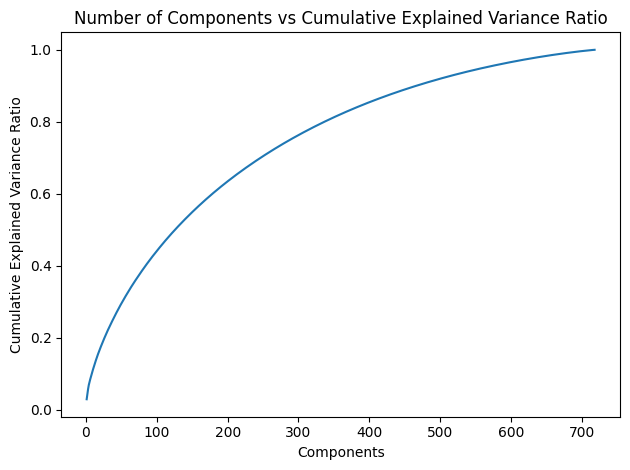

In [56]:
cum_evrAll = list(zip(range(1, UAll.shape[1] + 1), np.cumsum(svdAll.explained_variance_ratio_)))

cum_evrAll_df = pd.DataFrame(cum_evrAll).set_index(0)

cum_evrAll_df.plot(title='Number of Components vs Cumulative Explained Variance Ratio',
                xlabel='Components',
                ylabel='Cumulative Explained Variance Ratio',
                legend=False)

plt.tight_layout()

The plot shows that 500 components are enough to explain around 90% of the cumulative explained variance ratio.

In [57]:
svd500 = TruncatedSVD(n_components=500)

U500 = svd500.fit_transform(X_centered)

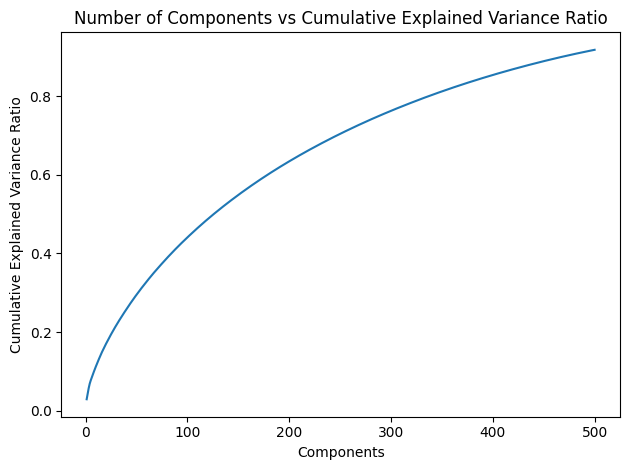

In [58]:
cum_evr500 = list(zip(range(1, U500.shape[1] + 1), np.cumsum(svd500.explained_variance_ratio_)))

cum_evr500_df = pd.DataFrame(cum_evr500).set_index(0)

cum_evr500_df.plot(title='Number of Components vs Cumulative Explained Variance Ratio',
                xlabel='Components',
                ylabel='Cumulative Explained Variance Ratio',
                legend=False)

plt.tight_layout()

# 4. Model evaluation and test/train split
<a id="4"></a>

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the pivot table into training and testing sets
train_pivot, test_pivot = train_test_split(pivot_tab, test_size=0.2, random_state=42)

print("Training Pivot Table Shape:", train_pivot.shape)
print("Testing Pivot Table Shape:", test_pivot.shape)

Training Pivot Table Shape: (4452, 718)
Testing Pivot Table Shape: (1114, 718)


In [60]:
# Centering the training data
X_train_centered = train_pivot - train_pivot.mean()
X_test_centered = test_pivot - train_pivot.mean() # Use training mean to center test data consistently

In [61]:
# Apply Truncated SVD on the training data
n_components = 500

svd = TruncatedSVD(n_components=n_components, random_state=42)
U_train = svd.fit_transform(X_train_centered)
Vt_train = svd.components_

In [62]:
# Function to predict ratings
def predict_ratings(user_embeddings, item_embeddings, user_mean):
    """Predicts ratings using the SVD model."""
    return np.dot(user_embeddings, item_embeddings) + user_mean

# Predict ratings for the training set
train_user_embeddings = U_train
predicted_train_ratings = predict_ratings(train_user_embeddings, Vt_train, train_pivot.mean(axis=1).values.reshape(-1, 1))

## 4.1 Evaluate on the training set

In [63]:
# Create lists to store actual and predicted ratings
actual_train_ratings = []
predicted_train_actuals = []

for user_id in train_pivot.index:
    for book_title in train_pivot.columns:
        if train_pivot.loc[user_id, book_title] != mean_rating:
            actual_train_ratings.append(train_pivot.loc[user_id, book_title])
            user_index = train_pivot.index.get_loc(user_id)
            book_index = train_pivot.columns.get_loc(book_title)
            predicted_train_actuals.append(predicted_train_ratings[user_index, book_index])

train_rmse = np.sqrt(mean_squared_error(actual_train_ratings, predicted_train_actuals))
print(f"\nTraining RMSE: {train_rmse}")


Training RMSE: 0.2873494190123755


In [64]:
actual_train_ratings

[5.0,
 7.0,
 7.0,
 5.0,
 7.0,
 5.0,
 5.0,
 5.0,
 5.0,
 10.0,
 6.0,
 7.0,
 5.0,
 10.0,
 8.0,
 9.0,
 10.0,
 8.0,
 5.0,
 9.0,
 10.0,
 9.0,
 10.0,
 10.0,
 10.0,
 9.0,
 9.0,
 10.0,
 6.0,
 6.0,
 7.0,
 8.0,
 3.0,
 10.0,
 6.0,
 6.0,
 7.0,
 5.0,
 4.0,
 5.0,
 7.0,
 8.0,
 8.0,
 7.0,
 9.0,
 9.0,
 6.0,
 7.0,
 9.0,
 5.0,
 8.0,
 8.0,
 8.0,
 10.0,
 5.0,
 5.0,
 5.0,
 9.0,
 7.0,
 6.0,
 10.0,
 7.0,
 8.0,
 9.0,
 8.0,
 7.0,
 9.0,
 8.0,
 8.0,
 9.0,
 8.5,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 6.0,
 10.0,
 7.0,
 9.0,
 10.0,
 9.0,
 10.0,
 4.0,
 7.0,
 7.0,
 7.0,
 9.0,
 8.0,
 9.0,
 8.0,
 9.0,
 7.0,
 5.0,
 7.0,
 8.0,
 8.0,
 6.0,
 10.0,
 5.0,
 10.0,
 6.0,
 9.0,
 9.0,
 7.0,
 7.0,
 8.0,
 7.0,
 7.0,
 8.0,
 10.0,
 7.0,
 7.0,
 9.0,
 7.0,
 5.0,
 10.0,
 7.0,
 8.0,
 7.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 9.0,
 10.0,
 9.0,
 10.0,
 10.0,
 10.0,
 8.0,
 9.0,
 8.0,
 8.0,
 9.0,
 4.0,
 7.0,
 9.0,
 7.0,
 10.0,
 9.0,
 8.0,
 8.0,
 10.0,
 7.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 7.0,
 8.0,
 8.0,
 7.0,
 7.0,
 10.0,
 10.0,
 10.0,
 8

In [65]:
predicted_train_actuals

[4.932905855567693,
 7.070264733081603,
 6.973191231626328,
 5.002755015414271,
 7.129550085567325,
 4.9293744448637895,
 4.942323446544828,
 4.971753078414258,
 6.029376079206907,
 9.904173953155416,
 6.156650710847479,
 7.177191186868637,
 4.973817341190517,
 8.576372334195455,
 7.969754501764151,
 8.164577476874392,
 9.998655831868481,
 7.981424187416275,
 5.104272780367693,
 9.043677775518313,
 9.834094484487508,
 8.419476459152571,
 9.995788053273278,
 9.507084194805072,
 9.549405605974211,
 8.97220965269571,
 9.033230970189747,
 9.906939619334242,
 5.96710228555275,
 6.286096746995787,
 7.011210279083016,
 7.955124594437735,
 3.478198566121648,
 9.976386317324966,
 5.912998316001223,
 5.838833680655992,
 6.912021840619622,
 4.817779363172573,
 6.196751490026918,
 5.086343698121828,
 7.015410558575718,
 8.023920949777601,
 8.00651184428122,
 7.716162370268274,
 8.976239770245321,
 8.969294507754897,
 6.7472442417079055,
 7.02770419871046,
 8.339743452354789,
 5.350310238319613,
 7

## 4.2 Predict ratings for the test set

In [66]:
U_test = svd.transform(X_test_centered)
predicted_test_ratings = predict_ratings(U_test, Vt_train, test_pivot.mean(axis=1).values.reshape(-1, 1))

In [67]:
predicted_test_ratings

array([[7.90740895, 7.92621073, 7.92909826, ..., 7.91448134, 7.92887243,
        7.93582286],
       [7.91992957, 7.94368954, 7.92954719, ..., 7.95417023, 7.92858459,
        7.92021116],
       [7.90785323, 7.92045696, 7.92399731, ..., 7.85208095, 7.90649582,
        7.91803868],
       ...,
       [7.88940504, 7.96614958, 7.92513214, ..., 8.06881952, 7.93207718,
        7.94095194],
       [7.91864266, 7.92693194, 7.6849486 , ..., 8.03514988, 7.90228166,
        8.01952959],
       [7.93966442, 7.91212063, 7.87618496, ..., 7.93216   , 7.90775038,
        7.9195375 ]])

## 4.3 Evaluate on the test set

In [68]:
# Optional: Generate recommendations for a user in the test set
if not test_pivot.empty:
    test_user_id = test_pivot.index[5]
    if test_user_id in X_test_centered.index:
        test_user_row = X_test_centered.loc[[test_user_id]]
        test_user_embedding = svd.transform(test_user_row)
        # Use the mean rating of the *test* set for this user
        user_mean_test = test_pivot.mean(axis=1).loc[[test_user_id]].values.reshape(-1, 1)
        predicted_ratings_for_user = predict_ratings(test_user_embedding, Vt_train, user_mean_test)
        predicted_ratings_series = pd.Series(predicted_ratings_for_user[0], index=train_pivot.columns)
        rated_books_test_user = test_pivot.loc[test_user_id][test_pivot.loc[test_user_id] != mean_rating].index
        recommendations = predicted_ratings_series.sort_values(ascending=False)
        recommendations = recommendations[~recommendations.index.isin(rated_books_test_user)].head(10)

        print(f"\nTop 10 Recommendations for User {test_user_id}:")
        print(recommendations)
    else:
        print(f"\nUser {test_user_id} not found in the centered test data.")
else:
    print("\nTest pivot table is empty, cannot generate recommendations.")


Top 10 Recommendations for User 276291:
Book-Title
The Death of Vishnu: A Novel                                                           8.267328
The Loop                                                                               8.212870
Lolita (Vintage International)                                                         8.197155
A Man in Full                                                                          8.187634
The Rapture of Canaan                                                                  8.185964
A Light in the Window (The Mitford Years)                                              8.161509
Sticks &amp; Scones                                                                    8.155402
Prodigal Summer                                                                        8.154373
The Weight of Water : A Novel Tag: Author of Resistance and Strange Fits of Passion    8.147992
Shock                                                                               

# 5. Predicting ratings for manually added user with SVD trained on the entire dataset

<a id="5"></a>

I want to make recommendations for a new user. 

First, I am creating a new user and I am filling its columns with NaNs.

In [69]:
vector_length = X_centered.shape[1]
new_user = np.full(vector_length, np.NaN)

new_user_df = pd.DataFrame([new_user], columns=X_centered.columns)
new_user_df

Book-Title,1984,1st to Die: A Novel,2nd Chance,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Confederacy of Dunces (Evergreen Book),A Darkness More Than Night,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Knight in Shining Armor,A Lesson Before Dying (Vintage Contemporaries (Paperback)),A Light in the Window (The Mitford Years),A Man Named Dave: A Story of Triumph and Forgiveness,A Man in Full,A Map of the World,A Painted House,A Prayer for Owen Meany,A Separate Peace,A Thousand Acres (Ballantine Reader's Circle),A Time to Kill,A Virtuous Woman (Oprah's Book Club (Paperback)),A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail),A Walk to Remember,A Widow for One Year,A Wrinkle In Time,A Wrinkle in Time,A Year in Provence,ANGELA'S ASHES,About a Boy,About a Boy (Movie Tie-In),Absolute Power,Accident,"Ahab's Wife: Or, The Star-Gazer: A Novel",Airframe,All Around the Town,All I Really Need to Know,All That Remains (Kay Scarpetta Mysteries (Paperback)),Along Came a Spider (Alex Cross Novels),American Gods,American Psycho (Vintage Contemporaries),And Then There Were None,Angela's Ashes (MMP) : A Memoir,Angela's Ashes: A Memoir,Angels,Angels &amp; Demons,"Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson",Animal Dreams,Animal Farm,Anne Frank: The Diary of a Young Girl,Anne of Avonlea (Anne of Green Gables Novels (Paperback)),Anne of Green Gables (Anne of Green Gables Novels (Paperback)),"Are You There God? It's Me, Margaret","Artemis Fowl (Artemis Fowl, Book 1)",Ashes to Ashes,At Home in Mitford (The Mitford Years),Atlas Shrugged,Atonement : A Novel,B Is for Burglar (Kinsey Millhone Mysteries (Paperback)),BAG OF BONES : A NOVEL,Back Roads,Bag of Bones,Balzac and the Little Chinese Seamstress : A Novel,Basket Case,Bastard Out of Carolina,Beach Music,Bee Season: A Novel,Before I Say Good-Bye,Bel Canto: A Novel,Beloved,Beloved (Plume Contemporary Fiction),Big Cherry Holler: A Big Stone Gap Novel (Ballantine Reader's Circle),Big Stone Gap: A Novel (Ballantine Reader's Circle),Big Trouble,Birthright,Black House,Black Notice,Black and Blue,Bleachers,Blessings,Blood Work,Bloody Bones (Anita Blake Vampire Hunter (Paperback)),Blow Fly: A Scarpetta Novel,Blue Diary,Body of Evidence (Kay Scarpetta Mysteries (Paperback)),Body of Lies,Brave New World,Breathing Lessons,Bridge to Terabithia,Bridget Jones : The Edge of Reason,Bridget Jones's Diary,Bridget Jones: The Edge of Reason,By the Light of the Moon,C Is for Corpse (Kinsey Millhone Mysteries (Paperback)),Call of the Wild,Carolina Moon,Carrie,Cat &amp; Mouse (Alex Cross Novels),Cat's Cradle,Catch 22,Catch Me If You Can: The True Story of a Real Fake,Catering to Nobody,Cause of Death,Certain Prey,Charlie and the Chocolate Factory,Charlotte's Web (Trophy Newbery),Charming Billy,Chasing the Dime,Chicken Soup for the Pet Lover's Soul (Chicken Soup for the Soul),Chicken Soup for the Soul (Chicken Soup for the Soul),Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper)),Chocolat,Choke,Chosen Prey,Christine,Circle of Friends,Circus of the Damned (Anita Blake Vampire Hunter (Paperback)),City of Bones,Code to Zero,Cold Mountain,Cold Mountain : A Novel,Cold Sassy Tree,Confessions of a Shopaholic (Summer Display Opportunity),Confessions of an Ugly Stepsister : A Novel,Congo,Contact,Coraline,Couplehood,Cradle and All,Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback)),Cryptonomicon,Cujo,D Is for Deadbeat (Kinsey Millhone Mysteries (Paperback)),Daddy's Little Girl,Daisy Fay and the Miracle Man,Dance upon the Air (Three Sisters Island Trilogy),Dark Paradise,Dark Rivers of the Heart,Deadly Decisions,Death du Jour,Deception Point,Deja Dead,Desecration: Antichrist Takes the Throne (Left Behind No. 9),Desperation,Diary of a Mad Bride (Summer Display Opportunity),Different Seasons,Digi

In [70]:
new_user_df['1984'] = 10
new_user_df['Jurassic Park'] = 7
new_user_df['The Catcher in the Rye'] = 8
new_user_df['Wuthering Heights'] = 10
new_user_df['Sisterhood of the Traveling Pants'] = 6
new_user_df['Life of Pi'] = 6
new_user_df['Like Water for Chocolate : A Novel in Monthly Installments with Recipes, Romances, and Home Remedies'] = 3
new_user_df['Last Man Standing'] = 7
new_user_df["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"] = 8
new_user_df['Harry Potter and the Chamber of Secrets (Book 2)'] = 9

new_user_df

Book-Title,1984,1st to Die: A Novel,2nd Chance,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Confederacy of Dunces (Evergreen Book),A Darkness More Than Night,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Knight in Shining Armor,A Lesson Before Dying (Vintage Contemporaries (Paperback)),A Light in the Window (The Mitford Years),A Man Named Dave: A Story of Triumph and Forgiveness,A Man in Full,A Map of the World,A Painted House,A Prayer for Owen Meany,A Separate Peace,A Thousand Acres (Ballantine Reader's Circle),A Time to Kill,A Virtuous Woman (Oprah's Book Club (Paperback)),A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail),A Walk to Remember,A Widow for One Year,A Wrinkle In Time,A Wrinkle in Time,A Year in Provence,ANGELA'S ASHES,About a Boy,About a Boy (Movie Tie-In),Absolute Power,Accident,"Ahab's Wife: Or, The Star-Gazer: A Novel",Airframe,All Around the Town,All I Really Need to Know,All That Remains (Kay Scarpetta Mysteries (Paperback)),Along Came a Spider (Alex Cross Novels),American Gods,American Psycho (Vintage Contemporaries),And Then There Were None,Angela's Ashes (MMP) : A Memoir,Angela's Ashes: A Memoir,Angels,Angels &amp; Demons,"Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson",Animal Dreams,Animal Farm,Anne Frank: The Diary of a Young Girl,Anne of Avonlea (Anne of Green Gables Novels (Paperback)),Anne of Green Gables (Anne of Green Gables Novels (Paperback)),"Are You There God? It's Me, Margaret","Artemis Fowl (Artemis Fowl, Book 1)",Ashes to Ashes,At Home in Mitford (The Mitford Years),Atlas Shrugged,Atonement : A Novel,B Is for Burglar (Kinsey Millhone Mysteries (Paperback)),BAG OF BONES : A NOVEL,Back Roads,Bag of Bones,Balzac and the Little Chinese Seamstress : A Novel,Basket Case,Bastard Out of Carolina,Beach Music,Bee Season: A Novel,Before I Say Good-Bye,Bel Canto: A Novel,Beloved,Beloved (Plume Contemporary Fiction),Big Cherry Holler: A Big Stone Gap Novel (Ballantine Reader's Circle),Big Stone Gap: A Novel (Ballantine Reader's Circle),Big Trouble,Birthright,Black House,Black Notice,Black and Blue,Bleachers,Blessings,Blood Work,Bloody Bones (Anita Blake Vampire Hunter (Paperback)),Blow Fly: A Scarpetta Novel,Blue Diary,Body of Evidence (Kay Scarpetta Mysteries (Paperback)),Body of Lies,Brave New World,Breathing Lessons,Bridge to Terabithia,Bridget Jones : The Edge of Reason,Bridget Jones's Diary,Bridget Jones: The Edge of Reason,By the Light of the Moon,C Is for Corpse (Kinsey Millhone Mysteries (Paperback)),Call of the Wild,Carolina Moon,Carrie,Cat &amp; Mouse (Alex Cross Novels),Cat's Cradle,Catch 22,Catch Me If You Can: The True Story of a Real Fake,Catering to Nobody,Cause of Death,Certain Prey,Charlie and the Chocolate Factory,Charlotte's Web (Trophy Newbery),Charming Billy,Chasing the Dime,Chicken Soup for the Pet Lover's Soul (Chicken Soup for the Soul),Chicken Soup for the Soul (Chicken Soup for the Soul),Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper)),Chocolat,Choke,Chosen Prey,Christine,Circle of Friends,Circus of the Damned (Anita Blake Vampire Hunter (Paperback)),City of Bones,Code to Zero,Cold Mountain,Cold Mountain : A Novel,Cold Sassy Tree,Confessions of a Shopaholic (Summer Display Opportunity),Confessions of an Ugly Stepsister : A Novel,Congo,Contact,Coraline,Couplehood,Cradle and All,Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback)),Cryptonomicon,Cujo,D Is for Deadbeat (Kinsey Millhone Mysteries (Paperback)),Daddy's Little Girl,Daisy Fay and the Miracle Man,Dance upon the Air (Three Sisters Island Trilogy),Dark Paradise,Dark Rivers of the Heart,Deadly Decisions,Death du Jour,Deception Point,Deja Dead,Desecration: Antichrist Takes the Throne (Left Behind No. 9),Desperation,Diary of a Mad Bride (Summer Display Opportunity),Different Seasons,Digi

In [71]:
# Impute
new_user_fillna_df = new_user_df.fillna(mean_rating)

# center the data
new_user_centered_df = new_user_fillna_df - X.mean()

new_user_centered_df

Book-Title,1984,1st to Die: A Novel,2nd Chance,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Confederacy of Dunces (Evergreen Book),A Darkness More Than Night,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Knight in Shining Armor,A Lesson Before Dying (Vintage Contemporaries (Paperback)),A Light in the Window (The Mitford Years),A Man Named Dave: A Story of Triumph and Forgiveness,A Man in Full,A Map of the World,A Painted House,A Prayer for Owen Meany,A Separate Peace,A Thousand Acres (Ballantine Reader's Circle),A Time to Kill,A Virtuous Woman (Oprah's Book Club (Paperback)),A Walk in the Woods: Rediscovering America on the Appalachian Trail (Official Guides to the Appalachian Trail),A Walk to Remember,A Widow for One Year,A Wrinkle In Time,A Wrinkle in Time,A Year in Provence,ANGELA'S ASHES,About a Boy,About a Boy (Movie Tie-In),Absolute Power,Accident,"Ahab's Wife: Or, The Star-Gazer: A Novel",Airframe,All Around the Town,All I Really Need to Know,All That Remains (Kay Scarpetta Mysteries (Paperback)),Along Came a Spider (Alex Cross Novels),American Gods,American Psycho (Vintage Contemporaries),And Then There Were None,Angela's Ashes (MMP) : A Memoir,Angela's Ashes: A Memoir,Angels,Angels &amp; Demons,"Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson",Animal Dreams,Animal Farm,Anne Frank: The Diary of a Young Girl,Anne of Avonlea (Anne of Green Gables Novels (Paperback)),Anne of Green Gables (Anne of Green Gables Novels (Paperback)),"Are You There God? It's Me, Margaret","Artemis Fowl (Artemis Fowl, Book 1)",Ashes to Ashes,At Home in Mitford (The Mitford Years),Atlas Shrugged,Atonement : A Novel,B Is for Burglar (Kinsey Millhone Mysteries (Paperback)),BAG OF BONES : A NOVEL,Back Roads,Bag of Bones,Balzac and the Little Chinese Seamstress : A Novel,Basket Case,Bastard Out of Carolina,Beach Music,Bee Season: A Novel,Before I Say Good-Bye,Bel Canto: A Novel,Beloved,Beloved (Plume Contemporary Fiction),Big Cherry Holler: A Big Stone Gap Novel (Ballantine Reader's Circle),Big Stone Gap: A Novel (Ballantine Reader's Circle),Big Trouble,Birthright,Black House,Black Notice,Black and Blue,Bleachers,Blessings,Blood Work,Bloody Bones (Anita Blake Vampire Hunter (Paperback)),Blow Fly: A Scarpetta Novel,Blue Diary,Body of Evidence (Kay Scarpetta Mysteries (Paperback)),Body of Lies,Brave New World,Breathing Lessons,Bridge to Terabithia,Bridget Jones : The Edge of Reason,Bridget Jones's Diary,Bridget Jones: The Edge of Reason,By the Light of the Moon,C Is for Corpse (Kinsey Millhone Mysteries (Paperback)),Call of the Wild,Carolina Moon,Carrie,Cat &amp; Mouse (Alex Cross Novels),Cat's Cradle,Catch 22,Catch Me If You Can: The True Story of a Real Fake,Catering to Nobody,Cause of Death,Certain Prey,Charlie and the Chocolate Factory,Charlotte's Web (Trophy Newbery),Charming Billy,Chasing the Dime,Chicken Soup for the Pet Lover's Soul (Chicken Soup for the Soul),Chicken Soup for the Soul (Chicken Soup for the Soul),Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper)),Chocolat,Choke,Chosen Prey,Christine,Circle of Friends,Circus of the Damned (Anita Blake Vampire Hunter (Paperback)),City of Bones,Code to Zero,Cold Mountain,Cold Mountain : A Novel,Cold Sassy Tree,Confessions of a Shopaholic (Summer Display Opportunity),Confessions of an Ugly Stepsister : A Novel,Congo,Contact,Coraline,Couplehood,Cradle and All,Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback)),Cryptonomicon,Cujo,D Is for Deadbeat (Kinsey Millhone Mysteries (Paperback)),Daddy's Little Girl,Daisy Fay and the Miracle Man,Dance upon the Air (Three Sisters Island Trilogy),Dark Paradise,Dark Rivers of the Heart,Deadly Decisions,Death du Jour,Deception Point,Deja Dead,Desecration: Antichrist Takes the Throne (Left Behind No. 9),Desperation,Diary of a Mad Bride (Summer Display Opportunity),Different Seasons,Digi

In [72]:
# Run the model that trained on the entire dataset
new_user_500d = svd500.transform(new_user_centered_df)

new_user_500d.shape

(1, 500)

In [73]:
# Predict
new_user_pred_centered  = np.dot(new_user_500d, svd500.components_)

new_user_pred_centered 

array([[ 2.08758745e+00,  7.87497478e-03, -7.53323613e-02,
        -1.42850089e-01,  4.84950027e-02,  6.26256778e-02,
         2.97444506e-02, -1.07855662e-02, -1.24941880e-01,
         4.07073715e-03, -1.58776504e-02, -2.08459829e-02,
        -5.12660735e-02, -5.38528958e-02,  5.93994626e-02,
        -1.09013630e-01,  1.25352324e-02,  1.20583898e-02,
         2.48710597e-02, -4.11770511e-02, -5.59901915e-02,
         1.24136063e-02,  9.53791510e-02,  1.17066923e-01,
         1.95645335e-02,  2.89973830e-02,  1.20795043e-01,
         3.96299682e-02, -1.35931759e-01, -1.20714642e-02,
         1.88123934e-02,  8.62857857e-02, -2.37307633e-02,
        -6.43392823e-02, -1.49941470e-01,  3.45442045e-02,
        -1.23377123e-02, -1.00016274e-01,  1.80335527e-01,
        -6.47449868e-02,  8.13862784e-02, -6.47000778e-02,
         3.56828394e-02, -5.94390665e-02,  9.47919418e-02,
        -3.04562876e-02, -2.03365294e-02, -1.91558536e-02,
         1.29598584e-02, -7.42194537e-02, -8.17204961e-0

In [74]:
# Uncenter the predictions to get them back to the original scale
new_user_pred = new_user_pred_centered + X.mean().values

new_user_recs = pd.DataFrame(new_user_pred, columns=X.columns)

top_recs = new_user_recs.T.sort_values(by=0, ascending=False)
top_recs.columns = ['Predicted_Rating']
top_recs.reset_index(inplace=True)

already_rated = new_user_df.T.dropna().index

top_recs_final = top_recs[~top_recs['Book-Title'].isin(already_rated)]
top_recs_final.head(10)

,Book-Title,Predicted_Rating
3,Charlie and the Chocolate Factory,8.430043
4,The House of the Spirits,8.313558
5,"Lamb : The Gospel According to Biff, Christ's ...",8.225769
6,The Last Juror,8.190371
7,The Lovely Bones,8.181835
8,Kitchen,8.176047
9,"Welcome to the World, Baby Girl!",8.166599
10,I Know Why the Caged Bird Sings,8.164741
11,In Her Shoes : A Novel,8.163350
12,One Hundred Years of Solitude,8.142921
